
# FACTR Knowledge Base – Dissertation Inspector

This notebook inspects the **entire FACTR knowledge base** and produces
publication-ready visuals and tables for the dissertation.

It assumes the following files exist **relative to the project root**:

- `data/processed/KB_passages.jsonl`
- `data/processed/KB_embeddings.npy`
- `data/processed/KB_embeddings.meta.json`
- `data/processed/LAST_KB.json` (optional but recommended)

If your paths differ, adjust the config cell below.


In [1]:

from pathlib import Path
import json
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
PROJECT_ROOT = Path.cwd()  # run this notebook from the project root
KB_PASSAGES_PATH = PROJECT_ROOT / "data" / "processed" / "KB_passages.jsonl"
KB_EMB_PATH = PROJECT_ROOT / "data" / "processed" / "KB_embeddings.npy"
KB_EMB_META_PATH = PROJECT_ROOT / "data" / "processed" / "KB_embeddings.meta.json"
LAST_KB_PATH = PROJECT_ROOT / "data" / "processed" / "LAST_KB.json"

KB_PASSAGES_PATH, KB_EMB_PATH, KB_EMB_META_PATH, LAST_KB_PATH


(WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/KB_passages.jsonl'),
 WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/KB_embeddings.npy'),
 WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/KB_embeddings.meta.json'),
 WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/LAST_KB.json'))

## 1. Embedding metadata and manifest

In [2]:

# Load embedding metadata
emb_meta = json.loads(KB_EMB_META_PATH.read_text(encoding="utf-8"))
emb = np.load(KB_EMB_PATH, mmap_mode="r")
rows, dim = emb.shape

print("Embedding file:", KB_EMB_PATH)
print("Shape:", emb.shape, "(rows, dim)")
print("Dtype:", emb.dtype)
print("\nEmbedding meta.json:")
for k, v in emb_meta.items():
    print(f"  {k}: {v}")

# Load LAST_KB manifest if present
if LAST_KB_PATH.exists():
    last_kb = json.loads(LAST_KB_PATH.read_text(encoding="utf-8"))
    print("\nLAST_KB.json:")
    for k, v in last_kb.items():
        if k != "artefacts":
            print(f"  {k}: {v}")
    print("\nArtefacts:")
    arts = last_kb.get("artefacts", {})
    for name, artefact in arts.items():
        print(f"  {name}: {artefact}")
else:
    last_kb = None
    print("\n[WARN] LAST_KB.json not found.")


Embedding file: c:\Users\lukmaan\Msc_in_AI\FATCR\data\processed\KB_embeddings.npy
Shape: (162712, 384) (rows, dim)
Dtype: float32

Embedding meta.json:
  model_name: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
  count: 162712
  dim: 384
  normalized: True

LAST_KB.json:
  time: 2025-11-18T12:18:54.419827Z
  dim: 384
  normalized: True
  model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Artefacts:
  all: {'faiss': 'data/processed/KB_all.faiss', 'map': 'data/processed/KB_all.map.jsonl'}
  islam: {'faiss': 'data/processed/KB_islam.faiss', 'map': 'data/processed/KB_islam.map.jsonl'}
  christian: {'faiss': 'data/processed/KB_christian.faiss', 'map': 'data/processed/KB_christian.map.jsonl'}
  passages: data/processed/KB_passages.jsonl


## 2. Full KB composition (no sampling)

In [3]:

traditions = Counter()
genres = Counter()
langs = Counter()
collections = Counter()
trad_genre = Counter()
trad_lang = Counter()

bucket_counts = Counter()  # hadith/tafsir/commentary/other

total_rows = 0

def bucket_row(rec: dict) -> str:
    """Rough heuristic buckets for hadith / tafsir / commentary."""
    genre = (rec.get("genre") or "").lower()
    coll = (rec.get("collection") or "").lower()

    if "hadith" in genre or "hadith" in coll:
        return "hadith"
    if "tafsir" in genre or "tafsīr" in genre or "tafsir" in coll or "tafsīr" in coll:
        return "tafsir"
    if "commentary" in genre or "commentary" in coll:
        return "commentary"
    return "other"

# A few examples per tradition and per (tradition, genre) for qualitative description
examples_by_trad = defaultdict(list)
examples_by_trad_genre = defaultdict(list)
MAX_EXAMPLES_PER_BUCKET = 2

with KB_PASSAGES_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        total_rows += 1
        rec = json.loads(line)

        t = rec.get("tradition") or "Unknown"
        g = rec.get("genre") or "Unknown"
        l = rec.get("lang") or "Unknown"
        c = rec.get("collection") or "Unknown"

        traditions[t] += 1
        genres[g] += 1
        langs[l] += 1
        collections[c] += 1

        trad_genre[(t, g)] += 1
        trad_lang[(t, l)] += 1

        b = bucket_row(rec)
        bucket_counts[b] += 1

        text = rec.get("text") or rec.get("passage") or ""
        if text:
            if len(examples_by_trad[t]) < MAX_EXAMPLES_PER_BUCKET:
                examples_by_trad[t].append({
                    "collection": c,
                    "genre": g,
                    "lang": l,
                    "text": text[:400].replace("\n", " "),
                })

            key_tg = (t, g)
            if len(examples_by_trad_genre[key_tg]) < MAX_EXAMPLES_PER_BUCKET:
                examples_by_trad_genre[key_tg].append({
                    "collection": c,
                    "lang": l,
                    "text": text[:400].replace("\n", " "),
                })

print("Total KB passages:", total_rows)

print("\nBy tradition:")
print(traditions)

print("\nBy genre:")
print(genres)

print("\nBy language:")
print(langs)

print("\nTop 15 collections:")
for name, count in collections.most_common(15):
    print(f"  {name!r:35} -> {count}")

print("\nBucket counts (hadith/tafsir/commentary/other):")
print(bucket_counts)


Total KB passages: 162712

By tradition:
Counter({'Islam': 100186, 'Christianity': 62526})

By genre:
Counter({'hadith': 75018, 'scripture': 57563, 'commentary': 17639, 'tafsir': 12472, 'creed': 20})

By language:
Counter({'en': 150128, 'ar': 12584})

Top 15 collections:
  'Nine Books'                        -> 75018
  'Bible'                             -> 44867
  'Commentaries-Database'             -> 17639
  'Quran'                             -> 12696
  'Tafsir Ibn Kathīr (EN)'            -> 6236
  'Tafsir al-Qurṭubī (AR)'            -> 6236
  'Ecumenical Creeds'                 -> 20

Bucket counts (hadith/tafsir/commentary/other):
Counter({'hadith': 75018, 'other': 57583, 'commentary': 17639, 'tafsir': 12472})


## 3. Visual summaries

In [4]:

def counter_series(counter: Counter, top_n: int | None = None) -> pd.Series:
    items = counter.most_common(top_n)
    if not items:
        return pd.Series(dtype="int64")
    labels, counts = zip(*items)
    return pd.Series(counts, index=labels)

def plot_bar(series: pd.Series, title: str, xlabel: str, ylabel: str, rotation: int = 45):
    plt.figure(figsize=(8, 5))
    series.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()


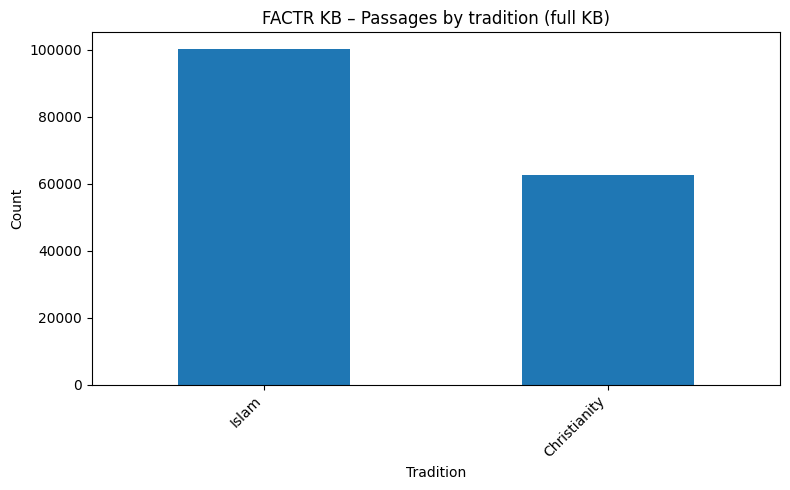

Islam           100186
Christianity     62526
dtype: int64

In [5]:

series_trad = counter_series(traditions)
plot_bar(series_trad, "FACTR KB – Passages by tradition (full KB)", "Tradition", "Count")
series_trad


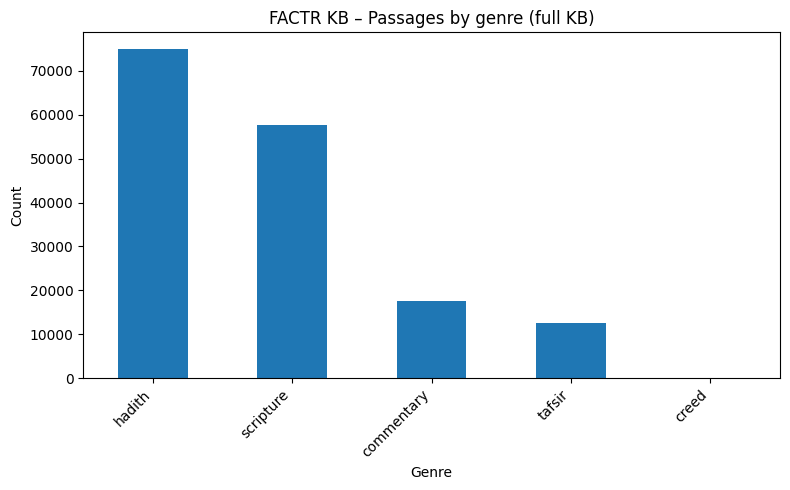

hadith        75018
scripture     57563
commentary    17639
tafsir        12472
creed            20
dtype: int64

In [6]:

series_genre = counter_series(genres)
plot_bar(series_genre, "FACTR KB – Passages by genre (full KB)", "Genre", "Count")
series_genre


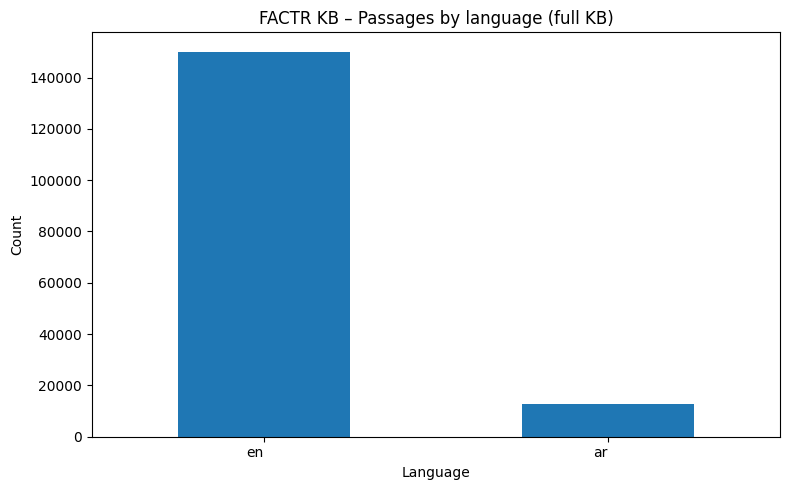

en    150128
ar     12584
dtype: int64

In [7]:

series_lang = counter_series(langs)
plot_bar(series_lang, "FACTR KB – Passages by language (full KB)", "Language", "Count", rotation=0)
series_lang


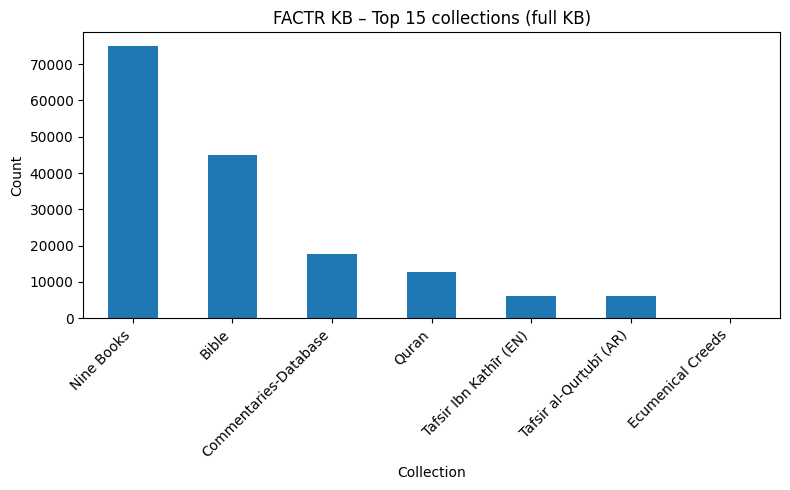

Nine Books                75018
Bible                     44867
Commentaries-Database     17639
Quran                     12696
Tafsir Ibn Kathīr (EN)     6236
Tafsir al-Qurṭubī (AR)     6236
Ecumenical Creeds            20
dtype: int64

In [8]:

series_coll = counter_series(collections, top_n=15)
plot_bar(series_coll, "FACTR KB – Top 15 collections (full KB)", "Collection", "Count")
series_coll


### 3.5 Genre distribution per tradition (stacked bar)

<Figure size 900x600 with 0 Axes>

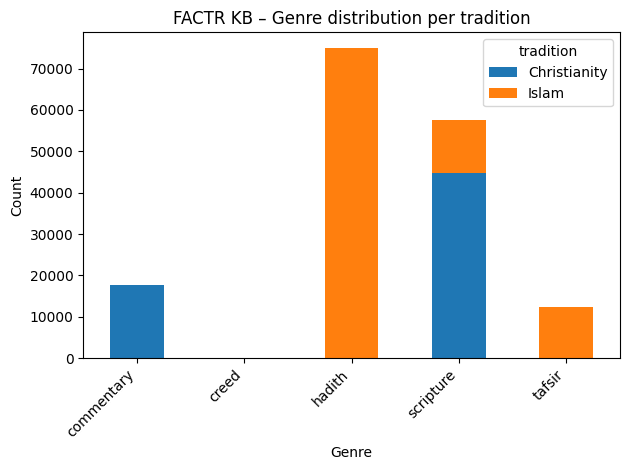

tradition,Christianity,Islam
genre,,
commentary,17639.0,0.0
creed,20.0,0.0
hadith,0.0,75018.0
scripture,44867.0,12696.0
tafsir,0.0,12472.0


In [9]:

rows_tg = [
    {"tradition": t, "genre": g, "count": cnt}
    for (t, g), cnt in trad_genre.items()
]
df_tg = pd.DataFrame(rows_tg)

pivot_tg = df_tg.pivot(index="genre", columns="tradition", values="count").fillna(0)

plt.figure(figsize=(9, 6))
pivot_tg.plot(kind="bar", stacked=True)
plt.title("FACTR KB – Genre distribution per tradition")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pivot_tg


### 3.6 Top collections per tradition

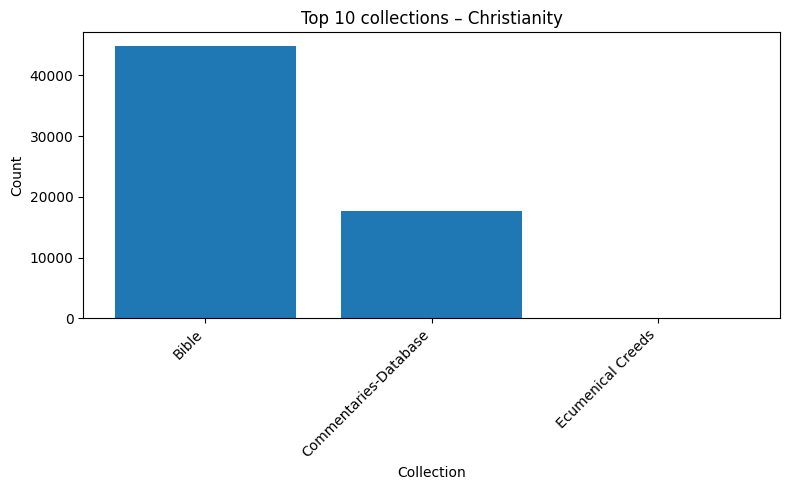

,tradition,collection,count
1,Christianity,Bible,44867
5,Christianity,Commentaries-Database,17639
6,Christianity,Ecumenical Creeds,20


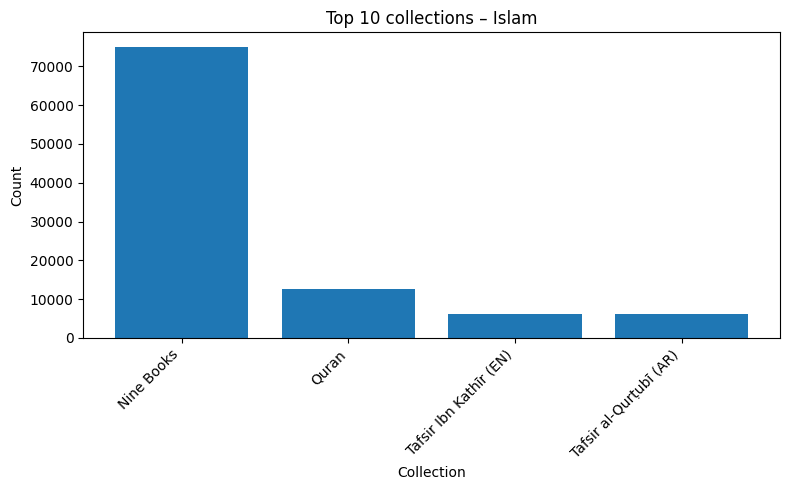

,tradition,collection,count
2,Islam,Nine Books,75018
0,Islam,Quran,12696
3,Islam,Tafsir Ibn Kathīr (EN),6236
4,Islam,Tafsir al-Qurṭubī (AR),6236


In [10]:

# Build a DataFrame with rows (tradition, collection, count)
rows_tc = []
# We don't have per-tradition collection counts directly, so we'll rescan quickly
trad_coll = Counter()
with KB_PASSAGES_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        t = rec.get("tradition") or "Unknown"
        c = rec.get("collection") or "Unknown"
        trad_coll[(t, c)] += 1

for (t, c), cnt in trad_coll.items():
    rows_tc.append({"tradition": t, "collection": c, "count": cnt})

df_tc = pd.DataFrame(rows_tc)

# Helper to plot top collections for a given tradition
def plot_top_collections_for_trad(trad_name: str, top_n: int = 10):
    sub = df_tc[df_tc["tradition"] == trad_name].sort_values("count", ascending=False).head(top_n)
    if sub.empty:
        print(f"No collections found for tradition={trad_name!r}")
        return
    plt.figure(figsize=(8, 5))
    plt.bar(sub["collection"], sub["count"])
    plt.title(f"Top {top_n} collections – {trad_name}")
    plt.xlabel("Collection")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    display(sub)

# Plot for major traditions we expect
for trad_name in sorted(traditions.keys()):
    plot_top_collections_for_trad(trad_name, top_n=10)


## 4. Hadith / Tafsir / Commentary coverage

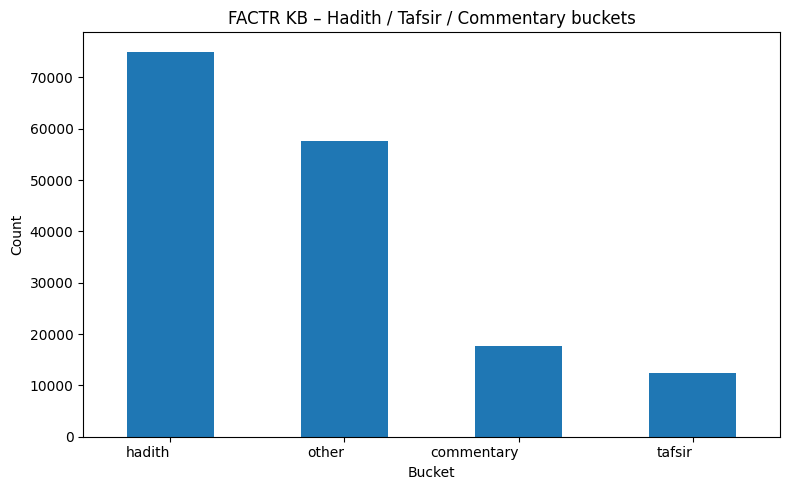

hadith        75018
other         57583
commentary    17639
tafsir        12472
dtype: int64

In [11]:

series_bucket = counter_series(bucket_counts)
plot_bar(series_bucket, "FACTR KB – Hadith / Tafsir / Commentary buckets", "Bucket", "Count", rotation=0)
series_bucket


### 4.1 Example passages per tradition

In [12]:

for trad, rows in examples_by_trad.items():
    print(f"\n=== Tradition: {trad} (examples: {len(rows)}) ===")
    for i, rec in enumerate(rows, start=1):
        print(f"\n[{trad} #{i}]")
        print("collection:", rec["collection"])
        print("genre     :", rec["genre"])
        print("lang      :", rec["lang"])
        print("text      :", rec["text"])



=== Tradition: Islam (examples: 2) ===

[Islam #1]
collection: Quran
genre     : scripture
lang      : en
text      : In the name of God, the Gracious, the Merciful.

[Islam #2]
collection: Quran
genre     : scripture
lang      : en
text      : Praise be to God, Lord of the Worlds.

=== Tradition: Christianity (examples: 2) ===

[Christianity #1]
collection: Bible
genre     : scripture
lang      : en
text      : {"type": "paragraph text", "chapterNumber": 1, "verseNumber": 1, "sectionNumber": 1, "value": "Adam, Seth, Enosh, "}

[Christianity #2]
collection: Bible
genre     : scripture
lang      : en
text      : {"type": "paragraph text", "chapterNumber": 1, "verseNumber": 2, "sectionNumber": 1, "value": "Kenan, Mahalalel, Jared, "}


## 5. Example passage structure (schema-style view)

In [13]:

# Grab the first record to illustrate field structure
with KB_PASSAGES_PATH.open("r", encoding="utf-8") as f:
    first_rec = json.loads(next(f))

print(json.dumps(first_rec, indent=2, ensure_ascii=False))

schema_df = pd.DataFrame(
    [{"field": k, "example_value": str(v)[:120]} for k, v in first_rec.items()]
).sort_values("field")

schema_df


{
  "tradition": "Islam",
  "genre": "scripture",
  "collection": "Quran",
  "source": "Quran (EN: semarketir/quranjson)",
  "lang": "en",
  "book": "Al-Fatiha",
  "chapter": 1,
  "verse": 1,
  "text": "In the name of God, the Gracious, the Merciful.",
  "ref": "Qur'an 1:1",
  "number": null,
  "grade": null,
  "group_key": "quran-1-1",
  "source_name": "quran_en",
  "source_collection": "Quran",
  "source_file": "data/raw/kb/_normalized/quran_en.jsonl"
}


,field,example_value
5,book,Al-Fatiha
6,chapter,1
2,collection,Quran
1,genre,scripture
11,grade,None
12,group_key,quran-1-1
4,lang,en
10,number,None
9,ref,Qur'an 1:1
3,source,Quran (EN: semarketir/quranjson)


## 6. Export summary tables for the dissertation

In [ ]:

OUT_DIR = PROJECT_ROOT / "data" / "kb_inspect_exports_full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def to_df(counter: Counter, top_n: int | None = None) -> pd.DataFrame:
    items = counter.most_common(top_n)
    if not items:
        return pd.DataFrame(columns=["label", "count"])
    labels, counts = zip(*items)
    return pd.DataFrame({"label": labels, "count": counts})

to_df(traditions).to_csv(OUT_DIR / "kb_by_tradition_full.csv", index=False)
to_df(genres).to_csv(OUT_DIR / "kb_by_genre_full.csv", index=False)
to_df(langs).to_csv(OUT_DIR / "kb_by_language_full.csv", index=False)
to_df(collections, top_n=100).to_csv(OUT_DIR / "kb_top_collections_full.csv", index=False)
to_df(bucket_counts).to_csv(OUT_DIR / "kb_buckets_full.csv", index=False)

# Also export cross-tabs
df_tg = pd.DataFrame(
    [{"tradition": t, "genre": g, "count": cnt} for (t, g), cnt in trad_genre.items()]
)
df_tg.to_csv(OUT_DIR / "kb_tradition_by_genre_full.csv", index=False)

df_tc.to_csv(OUT_DIR / "kb_tradition_by_collection_full.csv", index=False)

print("Exported:")
for p in OUT_DIR.glob("*.csv"):
    print(" -", p)


Exported:
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_buckets_full.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_by_genre_full.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_by_language_full.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_by_tradition_full.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_top_collections_full.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_tradition_by_collection_full.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports_full\kb_tradition_by_genre_full.csv
